In [1]:
import pandas as pd
data_path = '/kaggle/input/aerial-cactus-identification/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [2]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


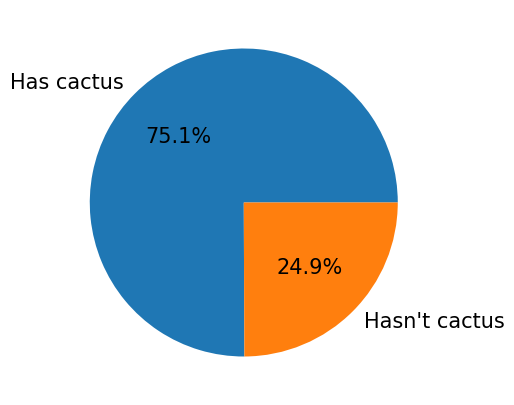

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(5,5))

label = ['Has cactus', 'Hasn\'t cactus']
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct = '%.1f%%');

In [4]:
from zipfile import ZipFile
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall()

with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall()

In [5]:
import os
num_train = len(os.listdir('train/'))
num_test = len(os.listdir('test/'))

num_train, num_test

(17500, 4000)

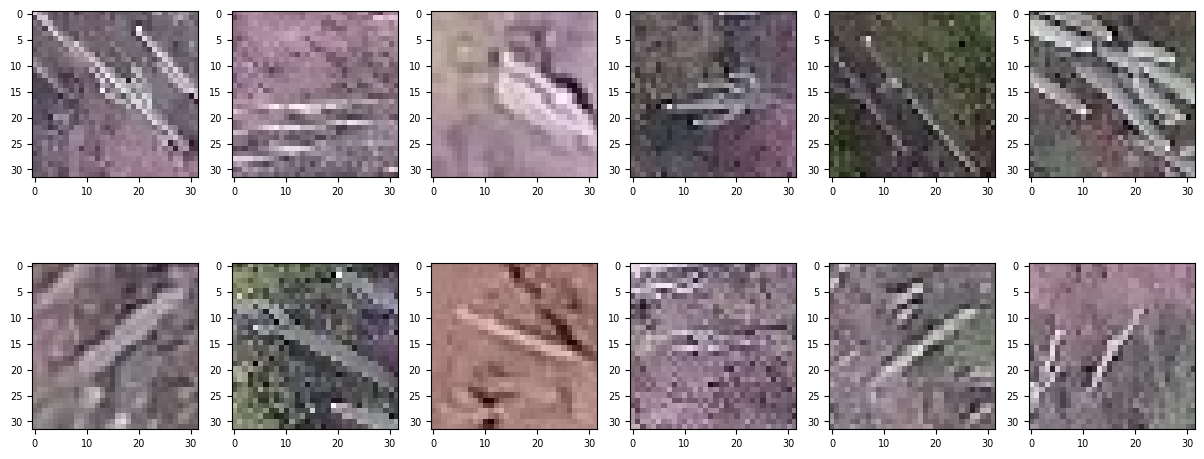

In [6]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15,6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = labels[labels['has_cactus'] == 1]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

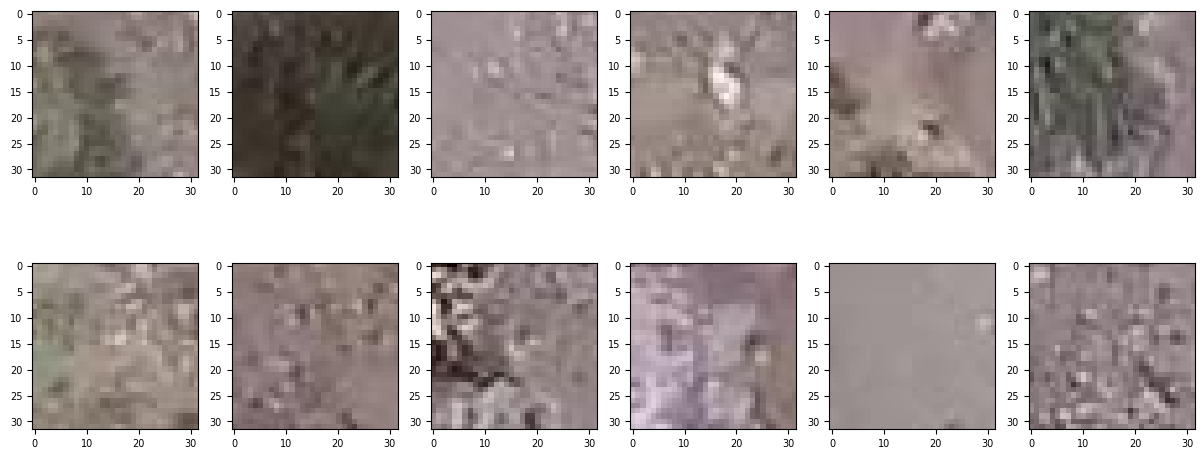

In [7]:
plt.figure(figsize=(15,6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = labels[labels['has_cactus'] == 0]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

In [8]:
import torch
import random
import numpy as np
import os
seed = 50
os.environ['PYTHONASHSEED'] = str(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cuda')

In [11]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(labels, test_size=0.1, stratify = labels['has_cactus'], random_state=50)

In [12]:
train.shape, valid.shape

((15750, 2), (1750, 2))

## 데이터셋 클래스 정의

In [13]:
import cv2
from torch.utils.data import Dataset

In [14]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx, 1]

        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [15]:
from torchvision import transforms
transform = transforms.ToTensor()

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x:x.view(-1)),
])

In [16]:
dataset_train = ImageDataset(df=train, img_dir = 'train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir = 'train/', transform=transform)

In [17]:
from torch.utils.data import DataLoader
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 32 x 32 x 3
        # out_channels 이 커널의 개수??
        # pooling크기와 stride 값은 같은 값으로 설정하는 게 일반적.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        self.fc = nn.Linear(in_features=64*4*4, out_features=2)

    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        return x

In [20]:
model = Model().to(device)

In [21]:
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in loader_train:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item( )
        loss.backward()
        optimizer.step()

        #print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

In [25]:
from sklearn.metrics import roc_auc_score
true_list = []
preds_list = []

In [26]:
model.eval()

with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        print(outputs)
        preds = torch.softmax(outputs.cpu(), dim=1)[:,1] #[:, 1]은 각 샘플에 대해 클래스 1의 확률만을 가져옵니다.
        true = labels.cpu()
        preds_list.extend(preds)
        true_list.extend(true)

print(f'ROC AUC:{roc_auc_score(true_list, preds_list):.4f}')

tensor([[-1.1891,  1.0218],
        [-1.1100,  0.9962],
        [-4.4977,  4.4453],
        [ 0.2156, -0.3616],
        [-1.9693,  1.8059],
        [-6.7202,  6.6620],
        [-5.8369,  5.8518],
        [-3.4885,  3.4654],
        [-0.9082,  0.7883],
        [-2.3554,  2.2153],
        [-0.1806,  0.0249],
        [-3.4590,  3.3669],
        [-8.0139,  8.0381],
        [-3.1496,  3.0135],
        [ 1.5404, -1.7524],
        [-2.8515,  2.6538],
        [-1.7575,  1.6084],
        [-4.0674,  3.9825],
        [-6.2878,  6.2305],
        [-2.3221,  2.2617],
        [-0.8645,  0.7748],
        [-1.6110,  1.5497],
        [-4.7786,  4.7512],
        [-4.9049,  4.7313],
        [-2.9789,  2.8277],
        [-6.3022,  6.2252],
        [-3.3014,  3.2176],
        [ 1.4475, -1.6300],
        [-2.9136,  2.8415],
        [-2.5687,  2.4465],
        [-3.2727,  3.1095],
        [-5.9394,  6.0807]], device='cuda:0')
tensor([[ 1.2539, -1.4185],
        [ 1.1162, -1.2586],
        [-6.7139,  6.8359],
  